In [15]:
from scipy.stats.mstats import winsorize
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
import datetime as dt
import zipfile
import gzip
import warnings
warnings.filterwarnings("ignore")

import config
from pathlib import Path

OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
START_DATE = config.START_DATE
END_DATE = config.END_DATE

In [16]:
# Change default pandas display options
pd.options.display.max_columns = 25
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Change default figure size
plt.rcParams['figure.figsize'] = 6, 5

# 1.Rating

In [133]:
def get_category_stats(df, subsamples, start_date=None, end_date=None, illiq=False):
    '''
    This function is used to calculate the ratios of the 3 rating categories,
    i.e. A and above, BBB, Junk in different periods
    as well as the total counts of the rating dates
    '''
    if not illiq:
        df['date'] = pd.to_datetime(df['date'])
    else:
        df['rating_date'] = pd.to_datetime(df['rating_date'])
        
    if not start_date:
        start_date = START_DATE
    if not end_date:
        if not illiq:
            end_date = df['date'].max()
        else:
            end_date = df['rating_date'].max()
    subsamples['All'] = (start_date, end_date)

    category_ratios = pd.DataFrame()
    rating_nums_dict = {}

    for subsample_name, (start_date, end_date) in subsamples.items():
        if not illiq:
            subsample_df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]
        else:
            subsample_df = df[(df['rating_date'] >= pd.to_datetime(start_date)) & (df['rating_date'] <= pd.to_datetime(end_date))]

        category_counts = subsample_df['category'].value_counts()
        category_ratio = category_counts / category_counts.sum()
        category_ratios[subsample_name] = category_ratio
        rating_nums_dict[subsample_name] = subsample_df.shape[0]

    rating_nums_df = pd.DataFrame(list(rating_nums_dict.items())).rename(columns={0:'category',1:'Total Counts'}).set_index('category')
    rating_stats = pd.concat([category_ratios.T, rating_nums_df], axis=1)

    rating_stats = rating_stats[['A and above', 'BBB', 'Junk', 'Total Counts']]
    
    return rating_stats

In [140]:
def plot_rating(df, illiq=False):
    '''
    This function is used to plot the proportions of the 3 rating categories,
    i.e. A and above, BBB, Junk in different periods
    and the total counts of the rating dates
    '''

    fig, ax1 = plt.subplots(figsize=(10, 6), dpi=200)

    for column in df.columns[:-1]: 
        ax1.plot(df.index, df[column], label=column)

    ax1.set_xlabel('Category')
    ax1.set_ylabel('Proportion', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()

    ax2.bar(df.index, df['Total Counts'], color='grey', alpha=0.6, label='Total Counts')

    ax2.set_ylabel('Total Counts', color='tab:grey')
    ax2.tick_params(axis='y', labelcolor='tab:grey')


    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    if not illiq:
        plt.title('Rating Category Proportions and Total Counts with Cleaned Illiquid Data')
    else:
        plt.title('Rating Category Proportions and Total Counts with Rating Data')

    plt.show()

In [135]:
illiq_rating = pd.read_csv(Path(DATA_DIR) / "pulled" / 'Illiqs_with_spread_bias.csv')

rating = pd.read_csv(Path(DATA_DIR) / "pulled" / 'rating.csv')

interested_columns = ['complete_cusip','rating_date', 'category', 'SPR']
subsamples = {
    'Full sample': ('2002-07-01', '2022-09-30'),
    'Pre-crisis': ('2002-07-01', '2007-06-30'),
    'Crisis': ('2007-07-01', '2009-04-30'),
    'Post-Crisis': ('2009-05-01', '2012-05-31'),
    'Basel II.5 & III': ('2012-06-01', '2014-03-31'),
    'Post-Volcker': ('2014-04-01', '2022-09-30'),
}

In [136]:
rating_stats = get_category_stats(rating, subsamples, illiq=True)
rating_stats

,A and above,BBB,Junk,Total Counts
Full sample,0.5960,0.1819,0.2221,830955
Pre-crisis,0.6237,0.1578,0.2185,233819
Crisis,0.6212,0.1599,0.2189,110961
Post-Crisis,0.6846,0.0999,0.2156,119859
Basel II.5 & III,0.5894,0.2041,0.2066,67101
Post-Volcker,0.5311,0.2368,0.2321,299215
All,0.5971,0.1830,0.2199,857776


In [137]:
rating_stats_illiq = get_category_stats(illiq_rating, subsamples)
rating_stats_illiq

,A and above,BBB,Junk,Total Counts
Full sample,0.2892,0.3699,0.3409,13400515
Pre-crisis,0.4248,0.2318,0.3435,1866446
Crisis,0.4697,0.2210,0.3093,745614
Post-Crisis,0.3254,0.3031,0.3715,1974617
Basel II.5 & III,0.2526,0.3879,0.3595,1190193
Post-Volcker,0.2346,0.4328,0.3326,7623645
All,0.2876,0.3776,0.3348,14293950


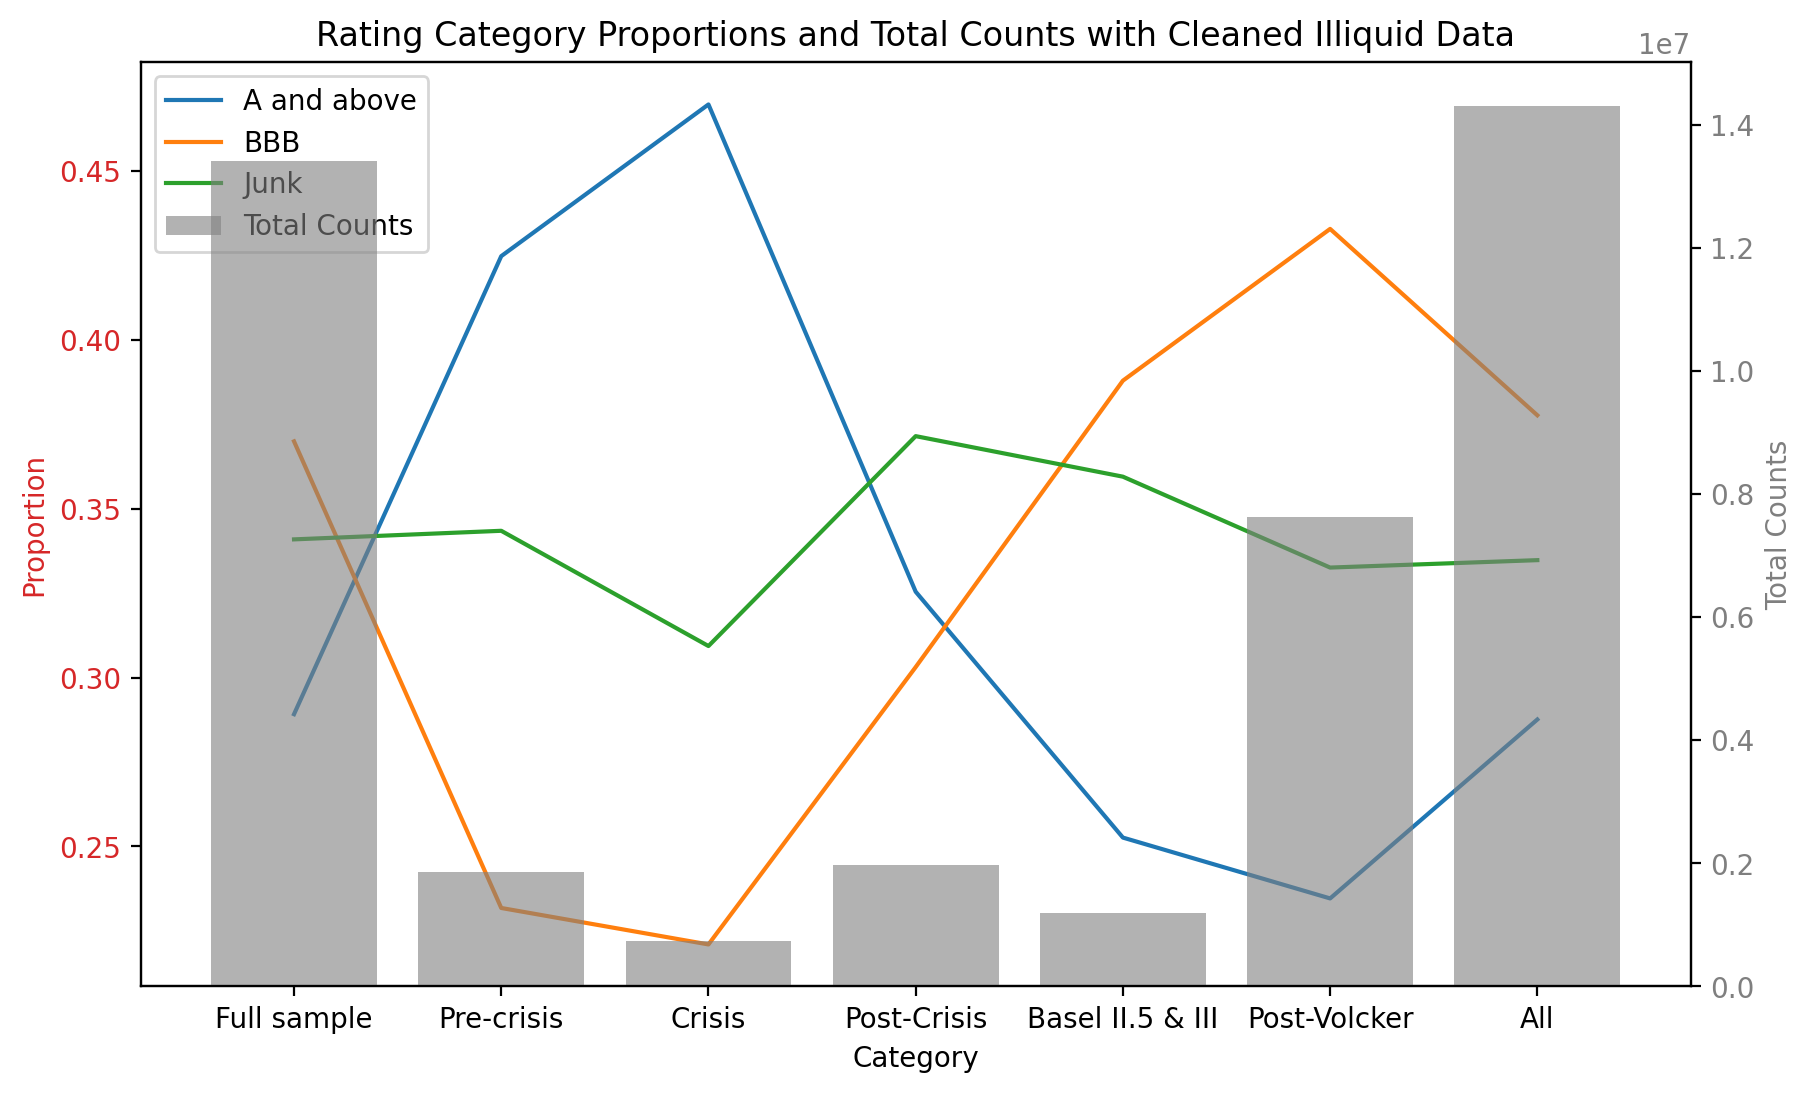

In [141]:
plot_rating(rating_stats_illiq)

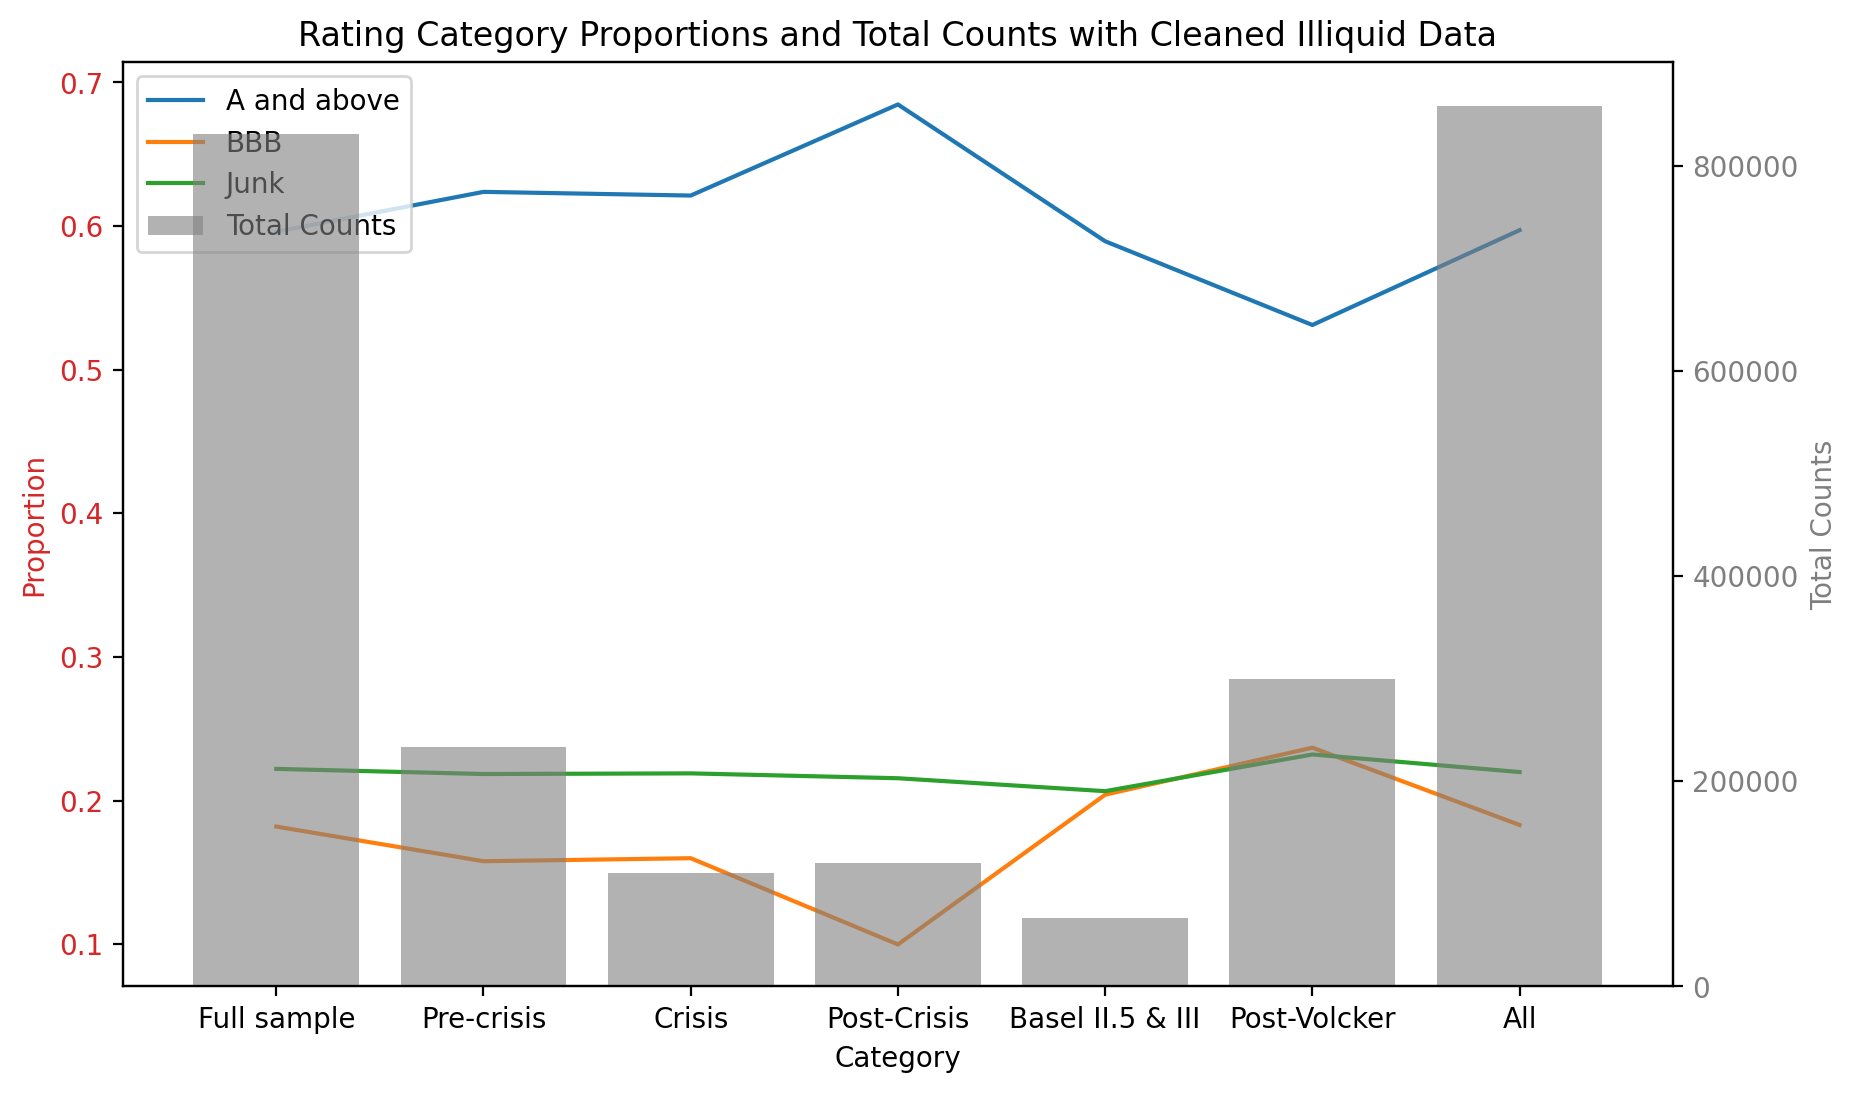

In [142]:
plot_rating(rating_stats)